# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 63437.67 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 98032.81 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 112900.55 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 133387.04 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 146012.65 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 153993.95 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 77427.68 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 111074.33 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 127005.41 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 137342.13 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143208.39 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 148427.72 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.94 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.94 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.24 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.41 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.83 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.66 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.40 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.72 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.68 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.79 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.53 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.70 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.35 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.76 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.57 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.11 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.65 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.92 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.24 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.39 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.90 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.06 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.24 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.70 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.32 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.40 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.44 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.25 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 34.77 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.60 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.95 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.66 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.45 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.05 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.92 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.25 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.80 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.73 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.55 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.53 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.82 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.54 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.02 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.07 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.63 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.93 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.85 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.85 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.20 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.30 examples/s]

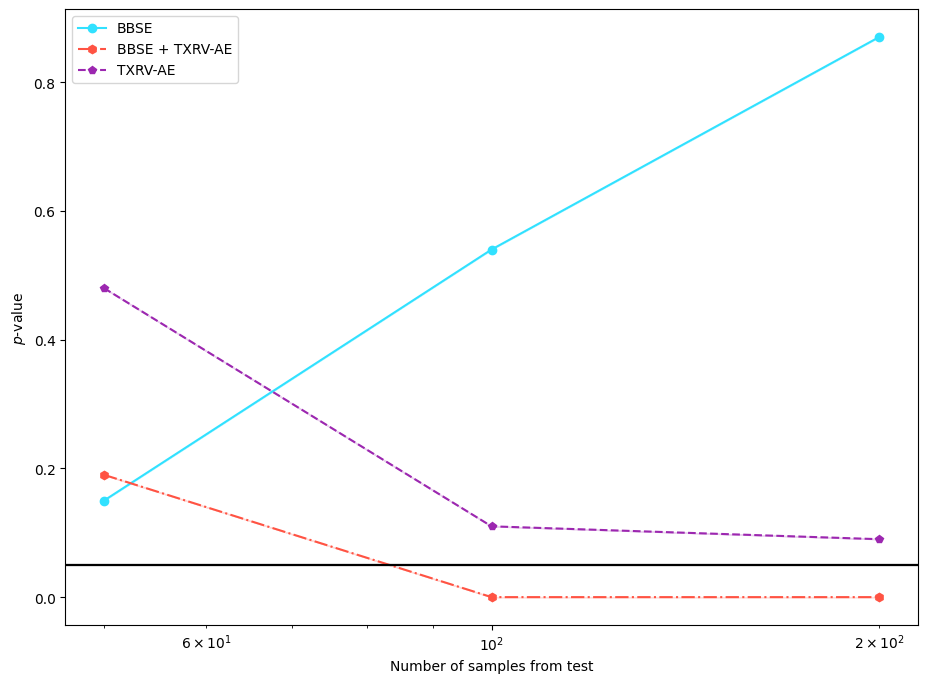

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.31 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.38 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.09 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.06 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.04 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.39 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.06 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.21 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.17 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.27 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.22 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.99 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.69 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.71 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.64 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.16 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.23 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.54 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.19 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.13 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.70 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.38 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.95 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.01 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.51 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.11 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.22 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.26 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.72 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.33 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.68 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.75 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.16 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.58 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.93 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.49 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.07 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.94 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.59 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.49 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.64 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.87 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.85 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.22 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.69 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.27 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.30 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.96 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.69 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.00 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.65 examples/s]

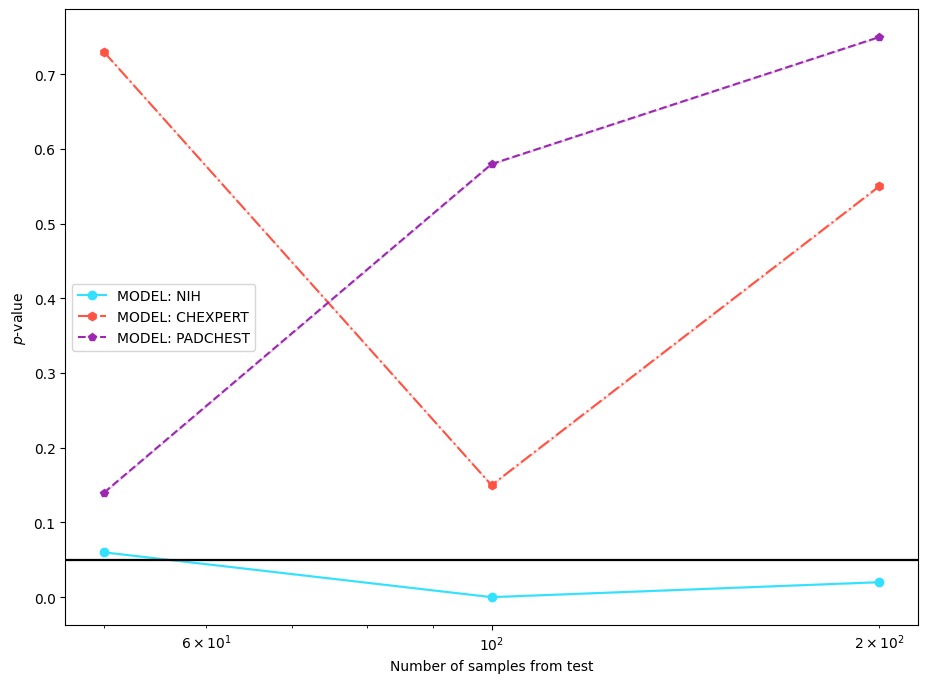

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56315.50 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81206.96 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95272.48 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98704.46 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 112463.23 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 115823.31 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 57547.38 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80741.60 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93003.25 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101247.64 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106240.17 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110255.76 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.60 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.19 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.66 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.05 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.08 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.47 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.67 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.97 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.99 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.99 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.94 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.05 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.05 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.84 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.98 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.51 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.20 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52294.30 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72912.87 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85147.39 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 96965.78 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 110160.90 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 122949.37 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 43832.21 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 65913.14 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 82081.72 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 93280.74 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100692.56 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106515.69 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.48 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.56 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.43 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.28 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.58 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 58.28 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.16 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.43 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.10 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.30 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.83 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.78 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.10 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.14 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.32 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.23 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54211.26 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73795.39 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86814.90 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102015.98 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 116124.87 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 126301.63 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 46945.60 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68296.02 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 82720.63 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 93495.08 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101184.08 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106540.05 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.35 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.86 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.44 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.59 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.32 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.30 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.39 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.39 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.20 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 41.24 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.23 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.10 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.19 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.16 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.75 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.32 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55239.86 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80172.71 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93279.11 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101287.81 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105605.37 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106775.52 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52799.57 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77426.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90364.32 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99190.95 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104348.30 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108856.19 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.51 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.39 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.05 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.96 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.67 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.44 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.93 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.97 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.09 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.65 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.94 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.83 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.60 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.34 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.93 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.43 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.96 examples/s]

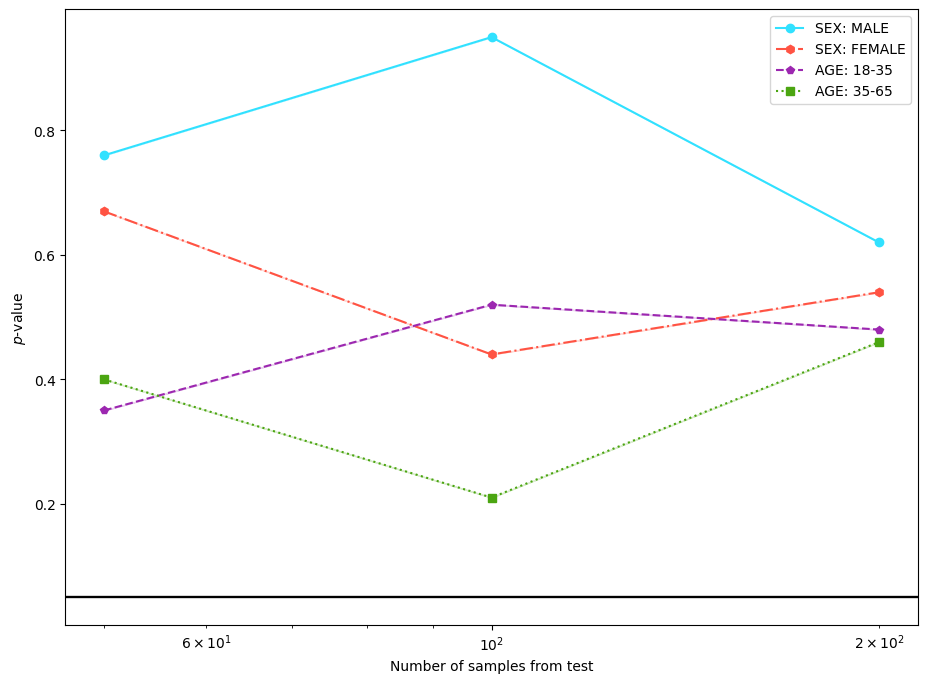

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.49 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.69 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.12 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.79 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.77 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.51 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.94 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.08 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.01 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.05 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.89 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.93 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.79 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.16 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 26.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.45 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.90 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.63 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.31 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.31 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.39 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.17 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.51 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.97 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.18 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.40 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.99 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.38 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.20 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.05 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.88 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.64 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.04 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.12 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.39 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.28 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.14 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.40 examples/s]

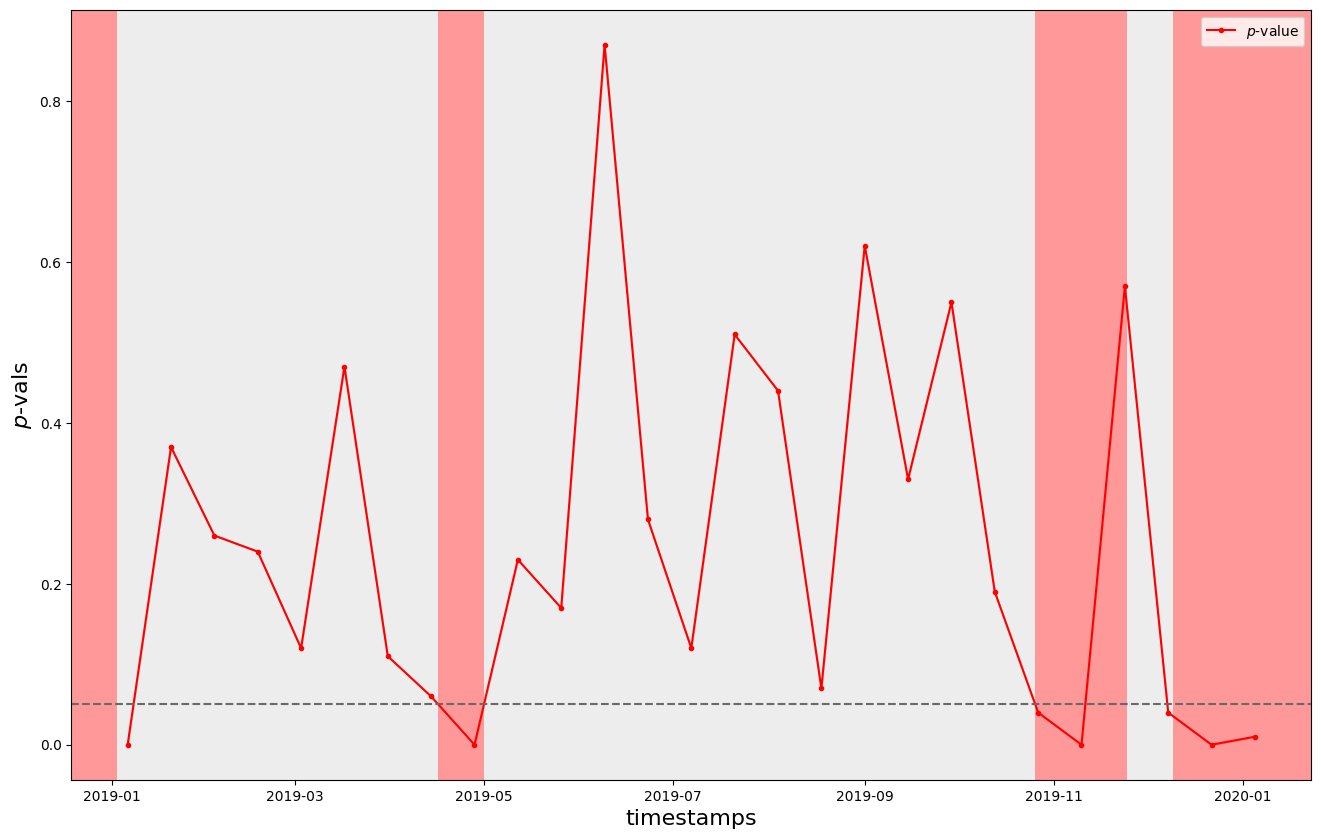

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)